In [1]:
import pandas as pd
import re
import glob
import os
from scipy import stats
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
colors = {
        "dark_purple": "#5F2E88",
        "purple": "#7E59A2",
        "light_purple": "#A17DB8",
        "pale_purple": "#dfd6e5",
        "dark_orange": "#F38227",
        "orange": "#E39943",
        "light_orange": "#EEBA7F",
        "pale_orange": "#f2d4b6",
        "dark_blue": "#3F60AC",
        "blue": "#7292C7",
        "light_blue": "#A5B3CC",
        "pale_blue": "#dae4f1",
        "dark_red": "#9C372F",
        "red": "#C76A6A",
        "light_red": "#E39C9D",
        "pale_red": "#edcccc",
        "dark_green": "#395A34",
        "green": "#688A2F",
        "light_green": "#B3CD86",
        "pale_green": "#d8e2c3",
        "dark_brown": "#764f2a",
        "brown": "#c2996c",
        "light_brown": "#e1bb96",
        "pale_brown": "#efccaf",
        "black": "#444147",
        "light_grey": "#EFEFEF",
        "light_gray": "#EFEFEF",
        "grey": "#6D6F72",
        "gray": "#6D6F72",
}

In [3]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
d2=dict((v, k) for k, v in d.items())

In [4]:
#read in all deep mutational files
path = '../Data/ProteinGym_substitutions/'
DMS_files=glob.glob(os.path.join(path, '*.csv'))

all_dms=[]
i=0
for f in DMS_files:
    dms=pd.read_csv(f)
    dms['mut_type']=dms['mutant'].str.replace('\d+','')
    dms['mut_type_len']=dms['mut_type'].str.len()
    dms=dms[dms['mut_type_len']==2]
    dms['fit_rank']=dms['DMS_score'].rank(pct=True)
    dms['pid']=i
    most_ties_number=pd.DataFrame(dms.DMS_score.value_counts()).reset_index()['index'][0]
    dms['f_ties']=np.mean(dms['DMS_score']==most_ties_number)
    dms['size']=len(dms)
    dms['mut_type_count']=len(dms.mut_type.unique().tolist())
    all_dms.append(dms)
    i=i+1
all_dms=pd.concat(all_dms)

In [5]:
#pre-process data frame
AA_list=['ARG','LYS','GLN','GLU','ASP',
         'ASN','HIS','SER','THR','ALA',
         'VAL','ILE','LEU','MET','PRO',
         'GLY','TYR','PHE','TRP','CYS']
aa_list=[d[a] for a in AA_list]

In [6]:
all_dms['AA1']=all_dms['mut_type'].str[0]
all_dms['AA2']=all_dms['mut_type'].str[1]

In [7]:
D_uniform=[]
p_uniform=[]
D_symmetry=[]
p_symmetry=[]
monotonic_r=[]
#grid plot
y_max_lim=[]
uniform_count=0
aa_pair=[]
for i in range(20):
    for j in range(20):
        if i!=j:
            data = all_dms[(all_dms['AA1']==aa_list[i])&(all_dms['AA2']==aa_list[j])]
            aa_pair.append(aa_list[i]+'-'+aa_list[j])
            #fit to get the lambda
            np.random.seed(0)
            data_array = np.array(data.fit_rank.tolist())
            counts, bins = np.histogram(data_array, bins=10, density=True)
            bins = bins[:-1]  # Removing the last bin edge
            monotonic_r.append(stats.spearmanr(counts,bins)[0])
            D,p=stats.kstest(data_array,stats.uniform.cdf)
            D_uniform.append(D)
            p_uniform.append(p)
            data_ji=all_dms[(all_dms['AA1']==aa_list[j])&(all_dms['AA2']==aa_list[i])]
            data_ji=np.array(data_ji.fit_rank.tolist())
            D2,p2=stats.ks_2samp(data_array,data_ji)
            D_symmetry.append(D2)
            p_symmetry.append(p2)


In [8]:
df_uniform_symmetry=pd.DataFrame({'AA_pair':aa_pair,
                                  'D_uniform':D_uniform,
                                  'p_uniform':p_uniform,
                                  'D_symmetry':D_symmetry,
                                  'p_symmetry':p_symmetry,
                                  'monotonic_r':monotonic_r})
df_uniform_symmetry['monotonic_r']=abs(df_uniform_symmetry['monotonic_r'])

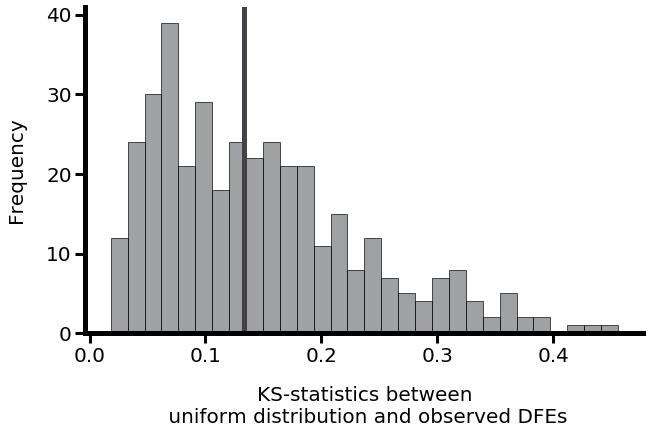

In [9]:
#FigS2a
plt.figure(figsize=(10, 6), facecolor='white')  # Adjust size and background color
result = plt.hist(D_uniform, bins=30, color=colors['gray'], edgecolor='k', alpha=0.65)
plt.axvline(np.median(D_uniform), color=colors['black'], linestyle='solid', linewidth=5)
plt.xlabel('KS-statistics between\n uniform distribution and observed DFEs',fontsize=20,labelpad=20)  # X-axis label
plt.ylabel('Frequency',fontsize=20,labelpad=20)        # Y-axis label
plt.xticks(fontsize=20)        # Adjust tick label size
plt.yticks(fontsize=20)
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=20)

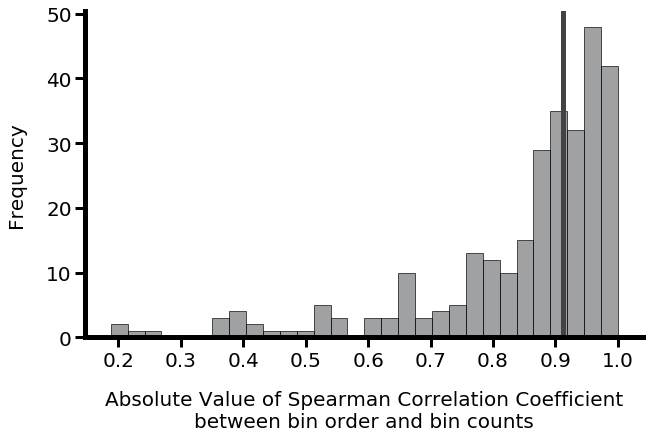

In [10]:
#FigS2b
plt.figure(figsize=(10, 6), facecolor='white')  # Adjust size and background color
r_list=df_uniform_symmetry[df_uniform_symmetry['p_uniform']<(0.05/380)].monotonic_r.tolist()
result = plt.hist(r_list, bins=30, color=colors['gray'], edgecolor='k', alpha=0.65)
plt.axvline(np.median(r_list), color=colors['black'], linestyle='solid', linewidth=5)
plt.xlabel('Absolute Value of Spearman Correlation Coefficient\nbetween bin order and bin counts',
           fontsize=20,labelpad=20)  # X-axis label
plt.ylabel('Frequency',fontsize=20,labelpad=20)          # Y-axis label
plt.xticks(fontsize=20)          # Adjust tick label size
plt.yticks(fontsize=20)
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=20)

In [11]:
df_uniform_symmetry.D_uniform.median()

0.133380168911736

In [12]:
sum((df_uniform_symmetry['p_uniform']*380)>0.05)

92

In [13]:
sum((df_uniform_symmetry['p_uniform']*380)>0.05)/380

0.24210526315789474

In [14]:
df_uniform_symmetry[df_uniform_symmetry['p_uniform']<(0.05/380)].monotonic_r.median()

0.9118583155200968

In [15]:
sum((df_uniform_symmetry['p_symmetry']*380)<0.05)

268

In [16]:
sum((df_uniform_symmetry['p_symmetry']*380)<0.05)/380

0.7052631578947368